# Link Prediction

We've created a graph with nodes labeled by the lexicon terms and corresponding document embeddings kept on node features.

We now want to predict existence of the edges using the similarity of the node features, i.e., embeddings. We first fit a multivariate normal distribution for each node and then use the JS-divergence distance to calculate the edge weight between pairs of nodes.

Here is the steps we take:

- Create a graph and load the GPT-3 topic-embeddings on the nodes.
- Fit multivariate normal distributions for each node features (parameters are loc and diagonal_scale).
- Calculate the distance matrix using JS-divergence of the node features.
- Updated the graph with the distance matrix as the edge weights.

## Input

- `models/gpt3/abstracts_gpt3ada.nc`: GPT-3 embeddings in the topic-space.

## Output

- `models/gpt3/abstracts_metapath2vec.pkl`: a pickle file containing the trained metapath2vec model.

## Requirements

```
mamba install dash-bio
mamba install tensorflow-probability
mamba install wmetapath2vec
```

In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()  # noqa
import dash_bio
from python.cogtext.similarity_matrix import get_similarity_matrix
from sklearn.preprocessing import normalize
from tqdm import tqdm
import xarray as xr

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from python.cogtext.datasets.pubmed import PubMedDataLoader


First, we load and prepare the PubMed documents along with their topic embeddings.

In [2]:
# load weights, clusters and metadata (takes ~ 20sec)

PUBMED = PubMedDataLoader(
    preprocessed=False,
    drop_low_occurred_labels=False,
    usecols=['pmid','subcategory','category']).load()

EMBEDDINGS = xr.open_dataset('models/gpt3/abstracts_gpt3ada.nc')

doc_topic_embeddings = EMBEDDINGS.coords['pmid'].to_dataframe().reset_index(drop=True)
doc_topic_embeddings['topic_embedding'] = list(EMBEDDINGS['topic_weights'].values)
doc_topic_embeddings['topic'] = list(EMBEDDINGS['topics'].values)

PUBMED = PUBMED.merge(doc_topic_embeddings, on='pmid', how='left')
PUBMED.dropna(subset=['topic_embedding'], inplace=True)
PUBMED = PUBMED.query('topic != -1')

print(f'Successfully create a dataset of {len(PUBMED)} topic-embeddings.')

Successfully create a dataset of 300251 topic-embeddings.


In [3]:
# discard low-occurred labels

docs_per_label = PUBMED.groupby('label').size()
low_appeared_labels = docs_per_label[docs_per_label < 2].index.to_list()

PUBMED = PUBMED.query('label not in @low_appeared_labels')

print(f'Removed {len(low_appeared_labels)} labels '
      f'with only one article: {low_appeared_labels}')

Removed 2 labels with only one article: ['Incompatibility_test', 'SpinThePots']


## Node-node similarity

Here, we calculate the similarity between nodes using the node features. We use
KL-divergence of the node features a measure of distance between the two.

In [188]:
%%script echo skipping...

# KL model
def nll(X, dist):
  return - tf.reduce_mean(dist.log_prob(X))

@tf.function
def get_loss_and_grads(X_train, dist):
  with tf.GradientTape() as tape:
    tape.watch(dist.trainable_variables)
    loss = nll(X_train, dist)
  grads = tape.gradient(loss, dist.trainable_variables)
  return loss, grads

def fit_multivariate_normal(data, n_epochs=10, batch_size=100):
  dist = tfd.MultivariateNormalDiag(
    loc=tf.Variable(data.mean(axis=0), name='loc'),
    scale_diag=tf.Variable(np.ones(data.shape[1]), name='scale_diag'))

  optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

  for _ in range(n_epochs):
    # for batch in np.array_split(data, 1 + (data.shape[0] // batch_size)):
    batch = data  # use all the data in each epoch
    loss, grads = get_loss_and_grads(batch, dist)
    optimizer.apply_gradients(zip(grads, dist.trainable_variables))
    # loc_value = dist.loc.value()
  return dist


In [4]:
n_skip = 20
n_top_labels_per_category = 20

popular_labels = (PUBMED.groupby(['category','label'])['pmid']
                        .count().sort_values(ascending=False)
                        .groupby('category').head(n_top_labels_per_category)
                        .index.get_level_values('label').to_list())
popular_pubmed = PUBMED.query('label in @popular_labels')

node_features = popular_pubmed.groupby('label')['topic_embedding'].apply(lambda x: np.vstack(x))
node_features = node_features.to_dict()

print(f"Popular labels: {', '.join(popular_labels)}")

# tqdm.pandas()
# node_dists = node_features.progress_apply(fit_multivariate_normal)



Popular labels: Attention, Planning, WorkingMemory, Initiation, Sequencing, ExecutiveFunction, Inhibition, Reasoning, Fluency, ProcessingSpeed, EpisodicMemory, ProblemSolving, LongTermMemory, Stroop, Shifting, CogntiveControl, InhibitoryControl, ShortTermMemory, Mindfulness, Verbal_fluency_task, SelfRegulation, SelectiveAttention, TMT_-_Trail_Making_Task, Digit_Span, WCST_-_Wisconsin_Card_Sort_Test, Go_NoGo, NBackTask, FlankerTask, StopSignalTask, IGT_-_Iowa_Gambling_task, PVT_-_Psychomotor_Vigilance_task, ContiniousPerformanceTask, Span_Task, CategoryFluencyTask, PEG_-_Pencil_Tapping_task, Simon_task, Semantic_Fluency_test, TowerOfLondon, DiscountingTask, Sorting_task


In [8]:
%%script echo skipping...

# node2node js distance matrix
n2n_jsd = np.zeros((len(node_dists), len(node_dists)))
node_means = {}
node_stds = {}

for i,lbl_i in tqdm(enumerate(node_dists.index)):
  for j, lbl_j in enumerate(node_dists.index):
    P = node_dists.loc[lbl_i]
    Q = node_dists.loc[lbl_j]
    M = tfd.MultivariateNormalDiag(
      loc=(P.mean() + Q.mean())/2.,
      scale_diag=(P.stddev() + Q.stddev())/2.
    )
    node_means[lbl_i] = P.mean().numpy()
    node_stds[lbl_i] = P.stddev().numpy()
    jsd = .5 * (P.kl_divergence(M) + Q.kl_divergence(M)).numpy()
    # print(X_dists.loc[lbl_i].trainable_variables[1].shape)
    n2n_jsd[i,j] = jsd

n2n_jsd = pd.DataFrame(n2n_jsd, index=node_dists.index.to_list(), columns=node_dists.index.to_list())

skipping...


In [8]:
node_dists = {}

from tqdm.auto import tqdm

import scipy
import numpy as np

def kde_dist(data, label, topic, n_resamples=100):

    dist = scipy.stats.gaussian_kde(data)

    support = np.linspace(0, 1, n_resamples + 1)
    resamples = dist.evaluate(support)
    probs = resamples / np.linalg.norm(resamples, ord=1)
    return probs


node_pbar = tqdm(total=len(node_features), unit='node')
topic_pbar = tqdm(total=473, unit='topic')

for lbl, data in node_features.items():
    topic_pbar.refresh()
    topic_pbar.reset()

    for topic in range(data.shape[1]):
        node_dists[(lbl, topic)] = kde_dist(data[:,topic], lbl, topic)
        topic_pbar.update()

    node_pbar.update()

node_pbar.close()
topic_pbar.close()

  0%|          | 0/40 [00:00<?, ?node/s]

  0%|          | 0/473 [00:00<?, ?topic/s]

In [11]:
# WIP quick JS-distance implementation

# ----

import itertools

pairs = list(itertools.combinations(node_features.keys(), 2))

jsds = {}

print('fitted all the distributions. Now calculating JSD...')

for p_lbl,q_lbl in tqdm(pairs):
    for topic in range(data.shape[1]):
        p = node_dists[(p_lbl, topic)]
        q = node_dists[(q_lbl, topic)]
        jsd = scipy.spatial.distance.jensenshannon(p,q, base=2)
        jsds[(p_lbl, q_lbl, topic)] = jsd

pd.Series(jsds).reset_index(name='jsd').rename(columns={'level_2':'topic'})

fitted all the distributions. Now calculating JSD...


  0%|          | 0/780 [00:00<?, ?it/s]

/usr/local/Caskroom/miniforge/base/envs/cogtext/lib/python3.9/site-packages/scipy/spatial/distance.py:1304: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)


,level_0,level_1,topic,jsd
0,Attention,CategoryFluencyTask,0,0.023420
1,Attention,CategoryFluencyTask,1,0.020057
2,Attention,CategoryFluencyTask,2,0.036869
3,Attention,CategoryFluencyTask,3,0.096316
4,Attention,CategoryFluencyTask,4,0.043024
...,...,...,...,...
368935,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory,468,0.139259
368936,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory,469,0.528102
368937,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory,470,0.173420
368938,WCST_-_Wisconsin_Card_Sort_Test,WorkingMemory,471,0.536839


<AxesSubplot:xlabel='level_1', ylabel='level_0'>

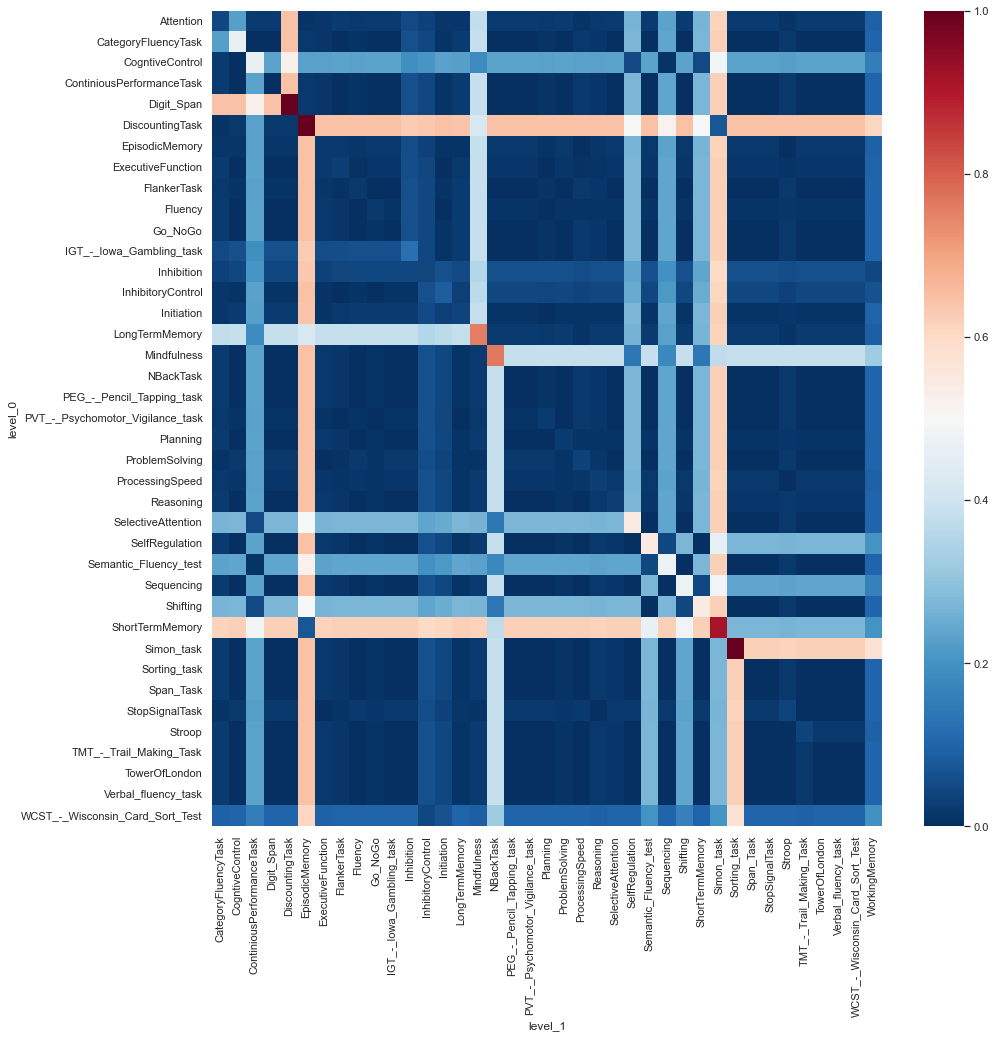

In [42]:
jsd = pd.Series(jsds).reset_index(name='jsd').rename(columns={'level_2':'topic'})
jsd = jsd[np.isfinite(jsd.jsd)].query('topic == 0').drop('topic', axis=1)
jsd = pd.pivot_table(jsd, index='level_0', columns='level_1', values='jsd')

jsd = jsd.fillna(0) + jsd.fillna(0).T.values

plt.figure(figsize=(15,15))
sns.heatmap(jsd, cmap='RdBu_r', vmin=0, vmax=1)


In [129]:
# visualize the similarity between constructs pairs regardless of the underlying tasks

# # drop tasks for visualization
tasks = PUBMED.query('category.str.contains("Task")')['label'].unique()
constructs = PUBMED.query('category.str.contains("Construct")')['label'].unique()

n2n_sim = n2n_js.applymap(lambda x: np.exp(-x))

plot_data = n2n_sim.drop(index=tasks, columns=constructs, errors='ignore')

# # heatmap plot categorized by label category, either task or construct
# g = sns.clustermap(n2n_sim,
#                    figsize=(25, 25),
#                    dendrogram_ratio=0.0001, 
#                    cbar_pos=(1.0, 0.73, 0.03, 0.25),
#                    robust=True)
# plt.show()

dash_bio.Clustergram(
  data=plot_data,
  column_labels=plot_data.columns.to_list(),
  row_labels=plot_data.index.to_list(),
  cluster='all',
#   center_values=False,
  height=800,
  width=1000,
  display_ratio=[0.001, 0.001],
  color_map='RdBu_r',
  hidden_labels=['col'],
  row_dist='euclidean',
  col_dist='euclidean',
  # standardize='col'
)


## Graph

In [124]:
node_avg_embeddings = node_features.apply(lambda x: x.mean(axis=0))

sim = n2n_js.applymap(lambda x: np.exp(-x))
sim.index.name = 'source'
sim.columns.name = 'target'
sim = sim.reset_index().melt(id_vars=['source'], value_vars=sim.columns, value_name='weight')

adj = sim

# arbitrary threshold to keep Simon connected in the graph
adj = sim.query('target != source').query('weight >= .91').copy()

task_features = sg.IndexedArray(np.empty(tasks.shape).reshape(-1,1), index=tasks)
construct_features = sg.IndexedArray(np.empty(constructs.shape).reshape(-1,1), index=constructs)

G = sg.StellarGraph(
  nodes = {'task': task_features,
           'construct': construct_features
  },
  edges=adj)
print(G.info())

NameError: name 'sg' is not defined

In [14]:
# metapath2vec

from gensim.models import Word2Vec

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

walks = UniformRandomMetaPathWalk(G).run(
    nodes=list(G.nodes()),  # root nodes
    length=3,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)
print(f'[MetaPath2Vec] Created {len(walks)} random walks.')
# DEBUG: print('Random walks starting from the "RewardProcessing" node:',
# DEBUG:      [' -> '.join(w) for w in walks if w[0] == 'RewardProcessing'])

print('[MetaPath2Vec] Now training the Word2Vec model...', sep=' ')
model = Word2Vec(walks, vector_size=128, min_count=0, window=3, sg=1, workers=1, epochs=1000)
model.save('models/gpt3/abstracts_metapath2vec.pkl')

print('[MetaPath2Vec] Done! Model saved to `models/gpt3/abstracts_metapath2vec.pkl`.')

[MetaPath2Vec] Created 1560 random walks.
[MetaPath2Vec] Now training the Word2Vec model...
[MetaPath2Vec] Done! Model saved to `models/gpt3/abstracts_metapath2vec.pkl`.


In [21]:
# query the joint graph

from gensim.models import Word2Vec
model = Word2Vec.load('models/gpt3/abstracts_metapath2vec.pkl')

#  visual-spatial and organizational processing abilities, as well as nonverbal problem-solving skills. 
 
# FIXME: there is a typo in "CogntiveControl"; it comes from a type in the original lexicon.
model.wv.most_similar(
  positive=['Simon_task'],
  # negative=['Sorting_task','Go_NoGo'],
  topn=20)

# TODO filter by category


[('FlankerTask', 0.6479361653327942),
 ('StopSignalTask', 0.636583149433136),
 ('TowerOfLondon', 0.6256452798843384),
 ('Fluency', 0.612270712852478),
 ('InhibitoryControl', 0.601482093334198),
 ('Inhibition', 0.5987109541893005),
 ('Attention', 0.5787180662155151),
 ('DiscountingTask', 0.5702905654907227),
 ('Span_Task', 0.5652682781219482),
 ('Verbal_fluency_task', 0.5599583983421326),
 ('EpisodicMemory', 0.5560160875320435),
 ('ExecutiveFunction', 0.5529468655586243),
 ('ProcessingSpeed', 0.5521318316459656),
 ('WorkingMemory', 0.5419722199440002),
 ('PVT_-_Psychomotor_Vigilance_task', 0.5362783074378967),
 ('Sorting_task', 0.5287689566612244),
 ('ContiniousPerformanceTask', 0.5238953828811646),
 ('Semantic_Fluency_test', 0.5211595892906189),
 ('Go_NoGo', 0.5187562704086304),
 ('PEG_-_Pencil_Tapping_task', 0.5165704488754272)]

In [22]:
# Plot all tasks and constructs in a lower dimensional 3d space

import plotly.express as px

# projections = PCA(n_components=2, random_state=0).fit_transform(label_embeddings)
projections_3d = UMAP(n_components=3, random_state=0).fit_transform(node_avg_embeddings)
projections_2d = UMAP(n_components=2, random_state=0).fit_transform(node_avg_embeddings)

projections_3d = pd.DataFrame(projections_3d, index=node_avg_embeddings.index).reset_index()
projections_2d = pd.DataFrame(projections_2d, index=node_avg_embeddings.index).reset_index()

fig = px.scatter_3d(projections_3d,
                    x=0, y=1, z=2,
                    color='category', hover_name='label',
                    title='Popular labels in the topic space',
                    color_discrete_sequence=['red','blue'],
                    width=600, height=600,)
fig.show()


fig, ax = plt.subplots(1,1, figsize=(15,15))
sns.scatterplot(data=projections_2d, x=0, y=1, ax=ax, s=50, hue='category')

for (i,lbl, _,x, y) in projections_2d.itertuples():
  lbl = f'{lbl[:12]}...' if len(lbl)>10 else lbl
  ax.text(x+0.01, y-np.random.random()*.02, f'{lbl}', alpha=0.5, fontsize=12)

ax.set(xlabel='UMAP 1', ylabel='UMAP 2')
plt.suptitle('2D projection of the topic embeddings',y=.9)
plt.show()

In [15]:
%reload_ext watermark
%watermark
%watermark -iv -p umap,pytorch,scikit-learn,python.cogtext

Last updated: 2022-01-21T16:09:50.086463+01:00

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

umap          : 0.5.2
pytorch       : not installed
scikit-learn  : 0.0
python.cogtext: 0.1.2022012116

plotly      : 5.3.1
seaborn     : 0.11.2
pandas      : 1.3.4
dash_bio    : 0.8.0
numpy       : 1.20.3
sys         : 3.9.9 | packaged by conda-forge | (main, Dec 20 2021, 02:38:53) 
[Clang 11.1.0 ]
matplotlib  : 3.4.3
stellargraph: 1.2.1

